<a href="https://colab.research.google.com/github/ibonetc/LLM_EPM/blob/main/IA_DL_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder convolucional

Un autoencoder es un algoritmo para compresión y descompresión de datos, con la paticularidad es capaz de reprodicir sólo datos similares a los que aprende. Lo más común es verlo como una red neuronal convolucional.

Se divide en dos componentes:

*   Encoder: Es el módulo encargado de comprimir los datos a un espacio latente
*   Decoder: Es el módulo encargado de descomprimir los datos, tratando de reconstruir la entrada original.





Los codificadores automáticos tienen pérdidas, lo que significa que las salidas descomprimidas se degradarán en comparación con las entradas originales.

En este ejemplo vamos a usar la base de datos MNIST para demostrar el uso de eliminación de ruido.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mlflow
import mlflow.tensorflow
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Flatten, Dense, Reshape,Conv2D,MaxPooling2D,Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [ ]:
mlflow.tensorflow.autolog()

## Cargando los datos
- Acá cada imagen tiene un tamaño de 28x28, lo que significa una entrada de 784

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalizar los datos
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### Reshape

Adicionar la tercera dimensión de la imagen (En las imágenes a color no es necesario hacer esto).

train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))

Otra opción de Reshape

train_data = x_train[..., tf.newaxis]
test_data = x_test[..., tf.newaxis]

In [ ]:
train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))
print (train_data.shape)
print (test_data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Ejemplo de eliminación de ruido

Para esto, vamos a crear unas imágenes con ruido a partir de las originales, para probar que el modelo sea capaz de reconstruir la imagen.

Se creará un encoder que comprima la imagen de una dimensión de 784 a 32 y un módulo decoder que la vuelva a **reconstruir**

### Crear imágenes con ruido

In [ ]:
noisy_array = train_data + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=train_data.shape)
noisy_train_data=np.clip(noisy_array, 0.0, 1.0)

In [ ]:
noisy_array = test_data + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
noisy_test_data=np.clip(noisy_array, 0.0, 1.0)

Mostrar primeras 10 imágenes, comparadas con las generadas con ruido

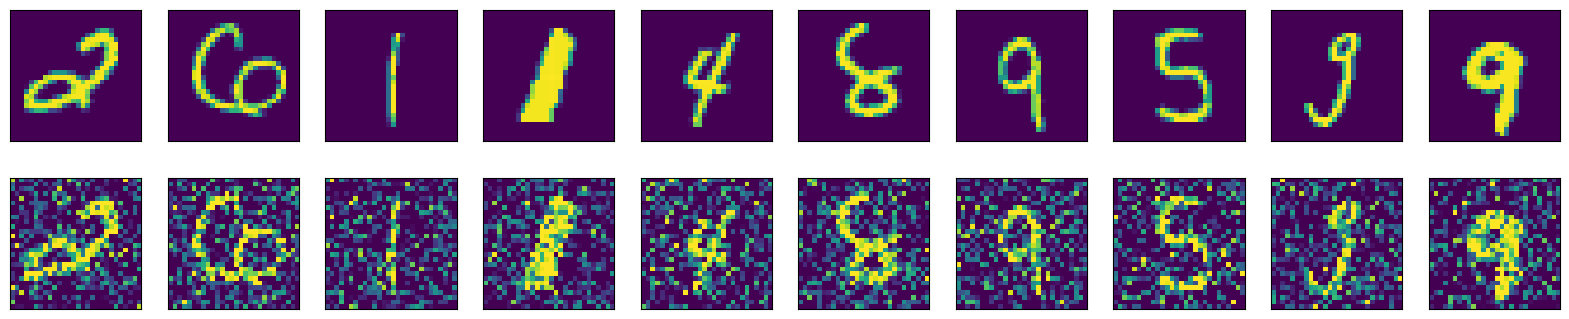

In [ ]:
indices = np.random.randint(len(train_data), size=10)
images1 = train_data[indices, :]
images2 = noisy_train_data[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

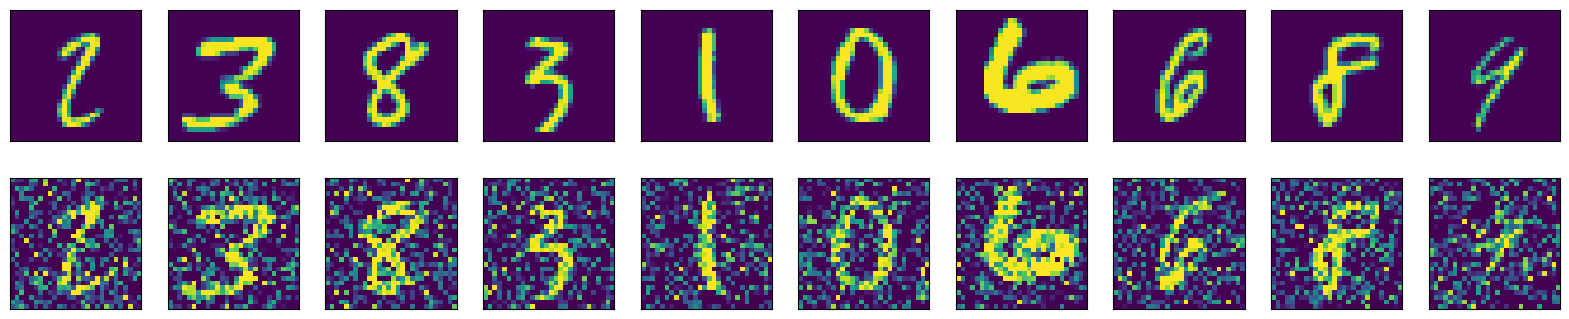

In [ ]:
indices = np.random.randint(len(test_data), size=10)
images1 = test_data[indices, :]
images2 = noisy_test_data[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### Ejemplo de modelo autoencoder

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
encoder = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
encoder = layers.MaxPooling2D((2, 2), padding="same")(encoder)
encoder = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder)
encoder = layers.MaxPooling2D((2, 2), padding="same")(encoder)

# Decoder
decoder = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoder)
decoder = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoder)
decoder = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(decoder)

# Autoencoder
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filepath = 'autoencoder_model.epoch{epoch:02d}-loss{val_loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [ ]:
with mlflow.start_run():
    autoencoder.fit(
        x=noisy_train_data,
        y=train_data,
        epochs=20,
        batch_size=128,
        shuffle=True,
        validation_data=(noisy_test_data, test_data),
        callbacks=[model_checkpoint_callback]
    )


Epoch 1/20
170/469 

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2967

469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - loss: 0.2965 - val_loss: 0.1040
Epoch 2/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 0.1045

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1031

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - loss: 0.1031 - val_loss: 0.0976
Epoch 3/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - loss: 0.0984

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0977

469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0977 - val_loss: 0.0946
Epoch 4/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0955

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0951

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0951 - val_loss: 0.0926
Epoch 5/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 0.0929

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0929

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0929 - val_loss: 0.0914
Epoch 6/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0918

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0918

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - loss: 0.0918 - val_loss: 0.0904
Epoch 7/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - loss: 0.0911

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0910

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.0910 - val_loss: 0.0896
Epoch 8/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0901

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0901

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0901 - val_loss: 0.0892
Epoch 9/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0896

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0896

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0896 - val_loss: 0.0886
Epoch 10/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0892

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0891

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0891 - val_loss: 0.0882
Epoch 11/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - loss: 0.0886

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0887

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - loss: 0.0887 - val_loss: 0.0879
Epoch 12/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 0.0884

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0884

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.0884 - val_loss: 0.0876
Epoch 13/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0882

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0881

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0881 - val_loss: 0.0873
Epoch 14/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0877

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0878

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.0878 - val_loss: 0.0872
Epoch 15/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 0.0878

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0877

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.0877 - val_loss: 0.0870
Epoch 16/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 0.0874

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0874

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0874 - val_loss: 0.0868
Epoch 17/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0873

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0872

469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - loss: 0.0872 - val_loss: 0.0865
Epoch 19/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 0.0873

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0871

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.0871 - val_loss: 0.0864
Epoch 20/20
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0867

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0867

469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 0.0867 - val_loss: 0.0862


2024/10/25 04:53:49 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2024/10/25 04:53:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/25 04:53:54 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.15.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

2024/10/25 04:53:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

2024/10/25 04:53:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-auk-858 at: adb-1961724828241313.13.azuredatabricks.net/ml/experiments/a424863758f54c2cbd394345916be78d/runs/ad78f4faa1364273972860334fe0190b.
2024/10/25 04:53:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-1961724828241313.13.azuredatabricks.net/ml/experiments/a424863758f54c2cbd394345916be78d.


In [ ]:
mlflow.end_run()

In [ ]:
'''
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)
'''

2024-10-25 03:16:24.094158: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-10-25 03:16:24.425097: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50
170/469[0

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2843

469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - loss: 0.2840 - val_loss: 0.1046
Epoch 2/50
168/469 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - loss: 0.1046

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1032

469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - loss: 0.1032 - val_loss: 0.0972
Epoch 3/50
168/469 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 0.0979

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0974

469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - loss: 0.0974 - val_loss: 0.0942
Epoch 4/50
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - loss: 0.0948

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0945

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - loss: 0.0945 - val_loss: 0.0924
Epoch 5/50
168/469 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 0.0930

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0927

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.0927 - val_loss: 0.0912
Epoch 6/50
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 0.0921

*** WARNING: max output size exceeded, skipping output. ***

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0917

469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - loss: 0.0917 - val_loss: 0.0901
Epoch 7/50
168/469 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.0906

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [ ]:
predictions = autoencoder.predict(noisy_test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


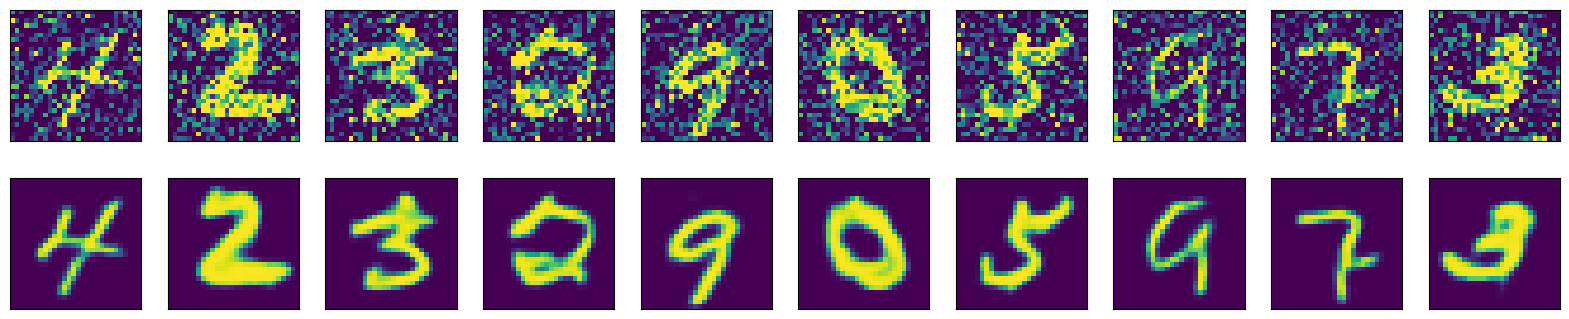

In [ ]:
indices = np.random.randint(len(noisy_test_data), size=10)
images1 = noisy_test_data[indices, :]
images2 = predictions[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## Ejemplo de detección de anomalías

Para esto utilizaremos un ejemplo [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Esta base de datos tiene 5000 electrocardiogramas, donde cada uno tiene 140 puntos. Los casos están etiquetados, donde 0 significa ritmo no normal y 1 ritmo normal.

La idea es poder identificar los ritmos con anomalías (no normales).

Este ejemplo, al ser supervisado se puede tratar con cualquier método de clasificación. Aquí la idea es mostrar un ejemplo donde, partiendo de un modelo que se entrene con casos de ritmo normal, sea capaz de identificar cuando no es normal.

### Cargar los datos

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

Como se puede ver la columna 140 tiene la etiqueta, y de la 0 a la 139 están los puntos de la señal del electrocardiograma.

In [ ]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2,stratify=labels)

In [ ]:
print(np.unique(train_labels,return_counts=True))
print(np.unique(test_labels,return_counts=True))

(array([0., 1.]), array([1663, 2335]))
(array([0., 1.]), array([416, 584]))


### Normalizar los datos

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

### Preparar los datos

Como vamos a entrenar el modelo sólo con los datos normales, entonces vamos a separar los que la etiqueta es 1 (label=1)

In [ ]:
train_labels

array([0., 0., 1., ..., 1., 0., 0.])

In [ ]:
train_labels==1

array([False, False,  True, ...,  True, False, False])

In [ ]:
one_train_labels=train_labels==1
one_test_labels=test_labels==1

In [ ]:
normal_train_data = train_data[one_train_labels]
normal_test_data = test_data[one_test_labels]

anomalous_train_data = train_data[~one_train_labels]
anomalous_test_data = test_data[~one_test_labels]

Ejemplo de una señal normal y otra con anomalía

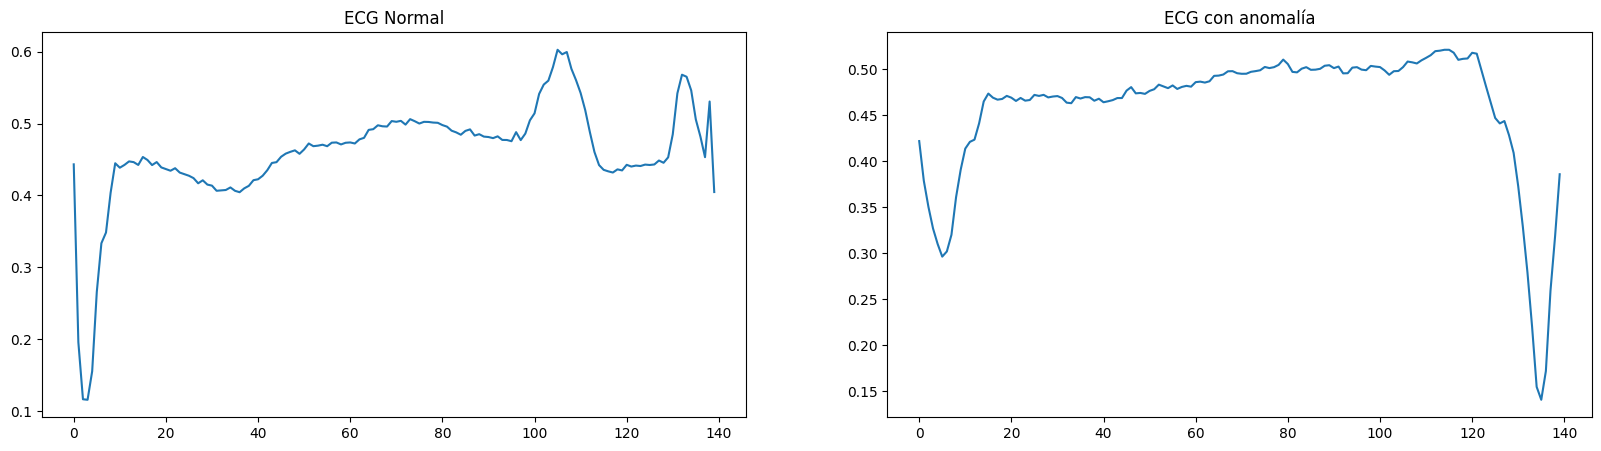

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(140), normal_train_data[0])
plt.title("ECG Normal")
plt.subplot(1, 2, 2)
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("ECG con anomalía")
plt.show()

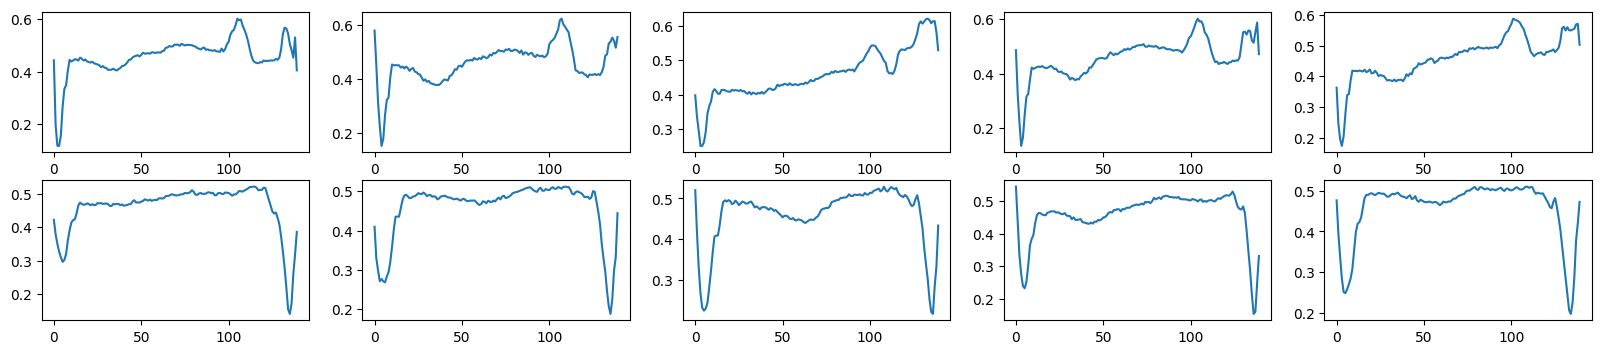

In [ ]:
n=5
plt.figure(figsize=(20, 4))
for i, (s1, s2) in enumerate(zip(normal_train_data[0:n], anomalous_train_data[0:n])):
  ax = plt.subplot(2, n, i + 1)
  plt.plot(np.arange(140), s1)
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(np.arange(140), s2)
plt.show()

In [ ]:
input= Input(shape=(140,))
encoder = Dense(32, activation="relu")(input)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)

decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(decoder)
decoder = Dense(140, activation="sigmoid")(decoder)

autoencoder=Model(input, decoder)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=50,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

2024/10/25 03:43:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1a0c9cd41f8147c79ff79f68003c7ba0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0582

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0578 - val_loss: 0.0528
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0560

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0555 - val_loss: 0.0509
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0534

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0526 - val_loss: 0.0493
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0499

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0492 - val_loss: 0.0477
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0468

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0460 - val_loss: 0.0453
Epoch 6/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0436

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0430 - val_loss: 0.0435
Epoch 7/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0412

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0403 - val_loss: 0.0421
Epoch 8/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0382

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0374 - val_loss: 0.0404
Epoch 9/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0346 - val_loss: 0.0390
Epoch 10/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0322

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0319 - val_loss: 0.0377
Epoch 11/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0298

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0295 - val_loss: 0.0367
Epoch 12/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0278

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0276 - val_loss: 0.0357
Epoch 13/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0265

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.0262 - val_loss: 0.0351
Epoch 14/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0255

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0251 - val_loss: 0.0345
Epoch 15/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0237

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0237 - val_loss: 0.0340
Epoch 16/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0233

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0231 - val_loss: 0.0336
Epoch 17/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0231

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0226 - val_loss: 0.0334
Epoch 18/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0220 - val_loss: 0.0328
Epoch 19/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0215 - val_loss: 0.0326
Epoch 20/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0212 - val_loss: 0.0325
Epoch 21/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0203

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0207 - val_loss: 0.0324
Epoch 22/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0204

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0204 - val_loss: 0.0321
Epoch 23/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - val_loss: 0.0322
Epoch 24/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - val_loss: 0.0322
Epoch 25/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0197

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0202 - val_loss: 0.0320
Epoch 26/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0211

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0204 - val_loss: 0.0319
Epoch 27/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0193

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0197 - val_loss: 0.0317
Epoch 28/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0194

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0198 - val_loss: 0.0316
Epoch 29/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0200

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0198 - val_loss: 0.0314
Epoch 30/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0203

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0200 - val_loss: 0.0313
Epoch 31/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0192

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0196 - val_loss: 0.0309
Epoch 32/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0194

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0196 - val_loss: 0.0307
Epoch 33/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0189

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0195 - val_loss: 0.0305
Epoch 34/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0201

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0197 - val_loss: 0.0303
Epoch 35/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0202

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0197 - val_loss: 0.0302
Epoch 36/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0196

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0195 - val_loss: 0.0299
Epoch 37/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0194

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0194 - val_loss: 0.0297
Epoch 38/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0192

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0193 - val_loss: 0.0292
Epoch 39/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0200

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0196 - val_loss: 0.0291
Epoch 40/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0196

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0194 - val_loss: 0.0288
Epoch 41/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193 - val_loss: 0.0289
Epoch 42/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0191

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0192 - val_loss: 0.0287
Epoch 43/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0206

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0194 - val_loss: 0.0285
Epoch 44/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0196

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0193 - val_loss: 0.0283
Epoch 45/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0191 - val_loss: 0.0284
Epoch 46/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0181

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0186 - val_loss: 0.0283
Epoch 47/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0184

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0186 - val_loss: 0.0280
Epoch 48/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0181

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0183 - val_loss: 0.0280
Epoch 49/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0182

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0182 - val_loss: 0.0279
Epoch 50/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179 - val_loss: 0.0279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

2024/10/25 03:43:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-midge-717 at: adb-1961724828241313.13.azuredatabricks.net/ml/experiments/a424863758f54c2cbd394345916be78d/runs/1a0c9cd41f8147c79ff79f68003c7ba0.
2024/10/25 03:43:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-1961724828241313.13.azuredatabricks.net/ml/experiments/a424863758f54c2cbd394345916be78d.


In [ ]:
autoencoder.save("autoencoder.keras")

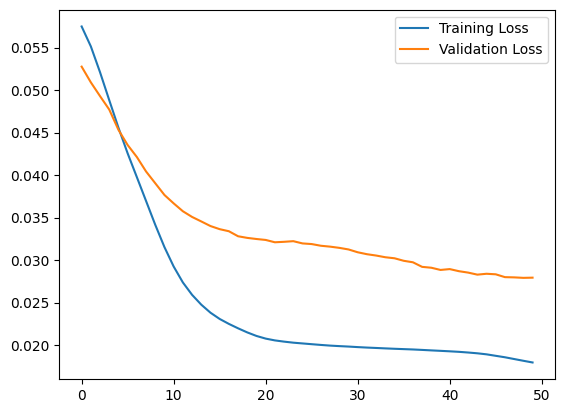

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Plot de una señal sin anomalía y una con anomalías

Ejemplo de señal normal:

In [ ]:
reconstructions = autoencoder(test_data)

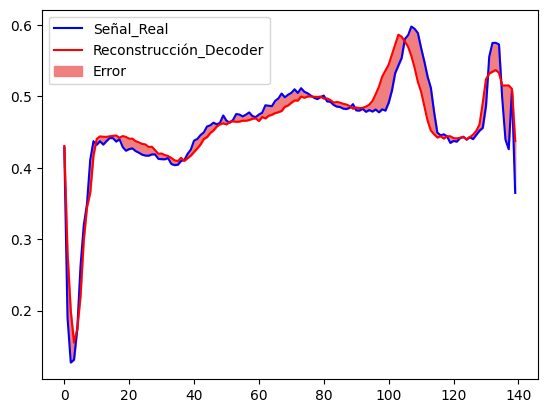

In [ ]:
plt.plot(normal_test_data[0], 'b')
plt.plot(reconstructions[0], 'r')
plt.fill_between(np.arange(140), reconstructions[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Señal_Real", "Reconstrucción_Decoder", "Error"])
plt.show()

Ejemplo de señal con anomalía

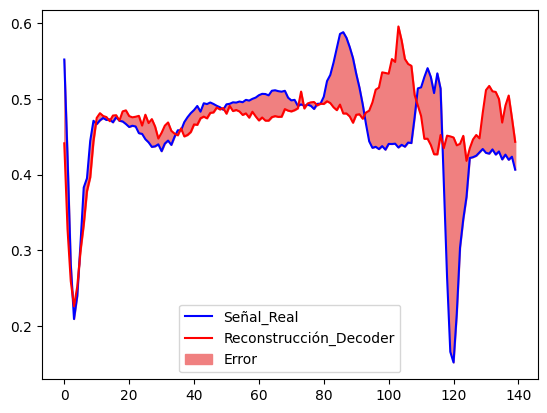

In [ ]:
reconstructions = autoencoder(anomalous_test_data)
plt.plot(anomalous_test_data[0], 'b')
plt.plot(reconstructions[0], 'r')
plt.fill_between(np.arange(140), reconstructions[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Señal_Real", "Reconstrucción_Decoder", "Error"])
plt.show()

### Dectección de anomalías


Para la detección de anomalía vamos a usar el error de la reconstrucción. Para esto podemos usar un umbral, que pudiera ser el error medio promedio para los ejemplos que tienen ritmo normal, con cierta desviación estándar.

Podemos estimar que la señal tiene anomalía si el error de reconstrucción de una señal está está por encima de ese umbral.


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


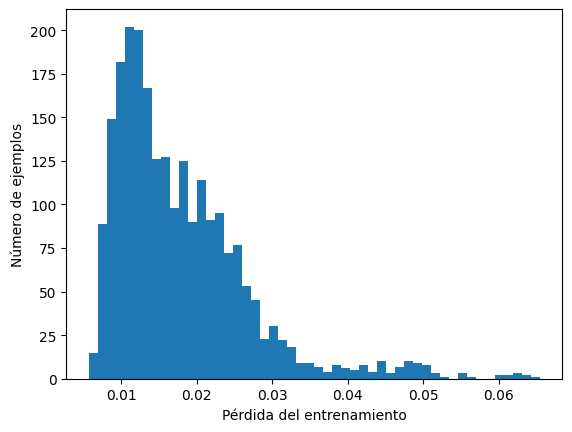

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel('Pérdida del entrenamiento')
plt.ylabel('Número de ejemplos')
plt.show()

Usando como umbral la media de la pérdida más la desviación estándar.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Umbral: ", threshold)

Umbral:  0.026843302


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


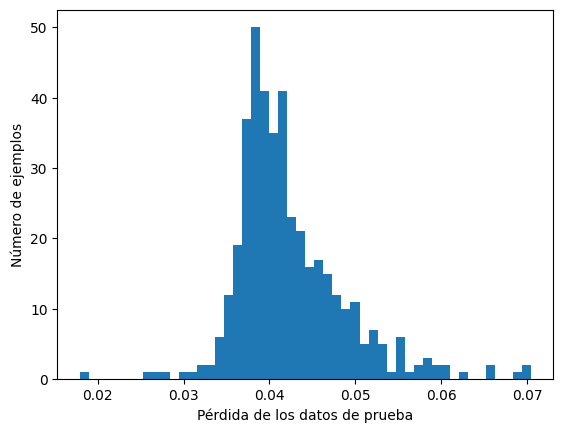

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Pérdida de los datos de prueba")
plt.ylabel("Número de ejemplos")
plt.show()

In [ ]:
# Predecir
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
predictions= tf.math.less(loss, threshold)

In [ ]:
print("Accuracy = {}".format(accuracy_score(test_labels, predictions)))
print("Precision = {}".format(precision_score(test_labels, predictions)))
print("Recall = {}".format(recall_score(test_labels, predictions)))

Accuracy = 0.935
Precision = 0.9961759082217974
Recall = 0.8921232876712328
